<a href="https://colab.research.google.com/github/qmeng222/transformers-for-NLP/blob/main/QA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question Answering with SQuAD (Stanford Question Answering Dataset) 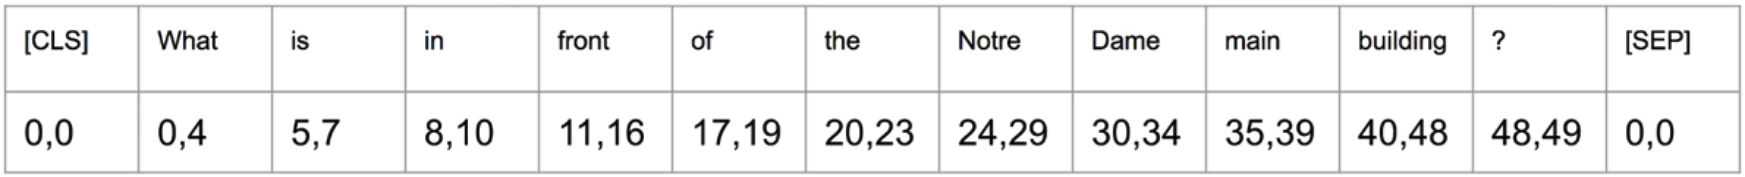

In [107]:
# install libraries:
!pip install transformers datasets
# `transformers` library: for using pre-trained models
# `datasets` library: to access a collection of high-quality datasets for NLP tasks

# Load & explore the SQuAD dataset:

In [108]:
from datasets import load_dataset # import the function

# load the dataset:
raw_datasets = load_dataset("squad")
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

👆 **train** and **validation** subsets

In [109]:
# explore the train subset:
raw_datasets["train"][1]

{'id': '5733be284776f4190066117f',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'What is in front of the Notre Dame Main Building?',
 'answers': {'text': ['a copper statue of Christ'], 'answer_start': [188]}}

👆 5 fields: 'id', 'title', 'context', 'question', 'answers'

'answers' has 'text' and  'answer_start' idx

In [110]:
# just to make sure each sample in the training has only 1 answer (no multi answers, or no anwers):
raw_datasets["train"].filter(lambda x: len(x["answers"]["text"]) != 1)

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 0
})

👆 Great, num_rows:0

(training set) for each question, there's only 1 answer

In [111]:
# explore the devset (validation subset):
# for validation set, there might be multiple answers
raw_datasets["validation"][2]

{'id': '56be4db0acb8001400a502ee',
 'title': 'Super_Bowl_50',
 'context': 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.',
 'question': 'Where did Super Bowl 50 take place?',
 'answers': {'text': ['Santa Clara, California',
   "Levi's Stadium",
   "Levi's Stadium in th

👆 (devset) for a single question, there might be multiple right answers  

In [112]:
# in devset, the answers for a single question might even be the same:
raw_datasets["validation"][0]

{'id': '56be4db0acb8001400a502ec',
 'title': 'Super_Bowl_50',
 'context': 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.',
 'question': 'Which NFL team represented the AFC at Super Bowl 50?',
 'answers': {'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'],


👆 'answers': {
                'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'],
                'answer_start': [177, 177, 177]
              }

# Load tokenizer:

In [113]:
from transformers import AutoTokenizer # import the class, enabling dynamic loading of tokenizer for a specific pre-trained model

checkpoint = "distilbert-base-cased" # model identifier (specify the name of a pre-trained model)
tokenizer = AutoTokenizer.from_pretrained(checkpoint) # automatically load the appropriate tokenizer

# Test the tokenizer:

In [114]:
# examine a sample from the training data:
raw_datasets["train"][1]

{'id': '5733be284776f4190066117f',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'What is in front of the Notre Dame Main Building?',
 'answers': {'text': ['a copper statue of Christ'], 'answer_start': [188]}}

In [115]:
# params:
question = raw_datasets["train"][1]["question"]
context = raw_datasets["train"][1]["context"]

# tokenize both the question and the context:
inputs = tokenizer(question, context)
inputs

{'input_ids': [101, 1327, 1110, 1107, 1524, 1104, 1103, 10360, 8022, 4304, 4334, 136, 102, 22182, 1193, 117, 1103, 1278, 1144, 170, 2336, 1959, 119, 1335, 4184, 1103, 4304, 4334, 112, 188, 2284, 10945, 1110, 170, 5404, 5921, 1104, 1103, 6567, 2090, 119, 13301, 1107, 1524, 1104, 1103, 4304, 4334, 1105, 4749, 1122, 117, 1110, 170, 7335, 5921, 1104, 4028, 1114, 1739, 1146, 14089, 5591, 1114, 1103, 7051, 107, 159, 21462, 1566, 24930, 2508, 152, 1306, 3965, 107, 119, 5893, 1106, 1103, 4304, 4334, 1110, 1103, 19349, 1104, 1103, 11373, 4641, 119, 13301, 1481, 1103, 171, 17506, 9538, 1110, 1103, 144, 10595, 2430, 117, 170, 14789, 1282, 1104, 8070, 1105, 9284, 119, 1135, 1110, 170, 16498, 1104, 1103, 176, 10595, 2430, 1120, 10111, 20500, 117, 1699, 1187, 1103, 6567, 2090, 25153, 1193, 1691, 1106, 2216, 17666, 6397, 3786, 1573, 25422, 13149, 1107, 8109, 119, 1335, 1103, 1322, 1104, 1103, 1514, 2797, 113, 1105, 1107, 170, 2904, 1413, 1115, 8200, 1194, 124, 11739, 1105, 1103, 3487, 17917, 114, 117

In [116]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask'])

In [117]:
print(inputs["input_ids"])

[101, 1327, 1110, 1107, 1524, 1104, 1103, 10360, 8022, 4304, 4334, 136, 102, 22182, 1193, 117, 1103, 1278, 1144, 170, 2336, 1959, 119, 1335, 4184, 1103, 4304, 4334, 112, 188, 2284, 10945, 1110, 170, 5404, 5921, 1104, 1103, 6567, 2090, 119, 13301, 1107, 1524, 1104, 1103, 4304, 4334, 1105, 4749, 1122, 117, 1110, 170, 7335, 5921, 1104, 4028, 1114, 1739, 1146, 14089, 5591, 1114, 1103, 7051, 107, 159, 21462, 1566, 24930, 2508, 152, 1306, 3965, 107, 119, 5893, 1106, 1103, 4304, 4334, 1110, 1103, 19349, 1104, 1103, 11373, 4641, 119, 13301, 1481, 1103, 171, 17506, 9538, 1110, 1103, 144, 10595, 2430, 117, 170, 14789, 1282, 1104, 8070, 1105, 9284, 119, 1135, 1110, 170, 16498, 1104, 1103, 176, 10595, 2430, 1120, 10111, 20500, 117, 1699, 1187, 1103, 6567, 2090, 25153, 1193, 1691, 1106, 2216, 17666, 6397, 3786, 1573, 25422, 13149, 1107, 8109, 119, 1335, 1103, 1322, 1104, 1103, 1514, 2797, 113, 1105, 1107, 170, 2904, 1413, 1115, 8200, 1194, 124, 11739, 1105, 1103, 3487, 17917, 114, 117, 1110, 170, 3

In [118]:
len(inputs["input_ids"])

177

In [119]:
# use the tokenizer to convert a sequence of token IDs back into human-readable text:
tokenizer.decode(inputs["input_ids"])

'[CLS] What is in front of the Notre Dame Main Building? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive ( and in a direct line that connects through 3 statues and the Gold Dome ), is a simple, modern stone statue of Mary. [SEP]'

👆 The **question** and **context** are concatenated into one string.

# Split long context into multiple (overlapping) windows:

In [120]:
inputs = tokenizer(
  question,
  context,
  max_length=100, # the max length of the resulting tokenized sequence (truncate or pad the sequence accordingly)
  truncation="only_second", # only 'context' will be truncated if the tokenized seq length exceeds max_length; 'question' will be left untouched
  stride=50, # if the combined length of the tokenized question and context exceeds max_length, the tokenizer will create overlapping chunks with a stride of 50 tokens (overlapping prev chunk by 50 tokens)
  return_overflowing_tokens=True, # tokenizer returns the remaining tokens that couldn't fit within the specified length
)

inputs

{'input_ids': [[101, 1327, 1110, 1107, 1524, 1104, 1103, 10360, 8022, 4304, 4334, 136, 102, 22182, 1193, 117, 1103, 1278, 1144, 170, 2336, 1959, 119, 1335, 4184, 1103, 4304, 4334, 112, 188, 2284, 10945, 1110, 170, 5404, 5921, 1104, 1103, 6567, 2090, 119, 13301, 1107, 1524, 1104, 1103, 4304, 4334, 1105, 4749, 1122, 117, 1110, 170, 7335, 5921, 1104, 4028, 1114, 1739, 1146, 14089, 5591, 1114, 1103, 7051, 107, 159, 21462, 1566, 24930, 2508, 152, 1306, 3965, 107, 119, 5893, 1106, 1103, 4304, 4334, 1110, 1103, 19349, 1104, 1103, 11373, 4641, 119, 13301, 1481, 1103, 171, 17506, 9538, 1110, 1103, 144, 102], [101, 1327, 1110, 1107, 1524, 1104, 1103, 10360, 8022, 4304, 4334, 136, 102, 4749, 1122, 117, 1110, 170, 7335, 5921, 1104, 4028, 1114, 1739, 1146, 14089, 5591, 1114, 1103, 7051, 107, 159, 21462, 1566, 24930, 2508, 152, 1306, 3965, 107, 119, 5893, 1106, 1103, 4304, 4334, 1110, 1103, 19349, 1104, 1103, 11373, 4641, 119, 13301, 1481, 1103, 171, 17506, 9538, 1110, 1103, 144, 10595, 2430, 117, 1

In [121]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'overflow_to_sample_mapping'])

👆 This time, 'overflow_to_sample_mapping' was introduced due to the `return_overflowing_tokens=True` setting.

NOTE: 101 and 102 are special tokens denoting the beginning and end of a sequence.

In [122]:
# what's the new key?
inputs['overflow_to_sample_mapping']

[0, 0, 0, 0]

In [123]:
inputs["input_ids"]

[[101,
  1327,
  1110,
  1107,
  1524,
  1104,
  1103,
  10360,
  8022,
  4304,
  4334,
  136,
  102,
  22182,
  1193,
  117,
  1103,
  1278,
  1144,
  170,
  2336,
  1959,
  119,
  1335,
  4184,
  1103,
  4304,
  4334,
  112,
  188,
  2284,
  10945,
  1110,
  170,
  5404,
  5921,
  1104,
  1103,
  6567,
  2090,
  119,
  13301,
  1107,
  1524,
  1104,
  1103,
  4304,
  4334,
  1105,
  4749,
  1122,
  117,
  1110,
  170,
  7335,
  5921,
  1104,
  4028,
  1114,
  1739,
  1146,
  14089,
  5591,
  1114,
  1103,
  7051,
  107,
  159,
  21462,
  1566,
  24930,
  2508,
  152,
  1306,
  3965,
  107,
  119,
  5893,
  1106,
  1103,
  4304,
  4334,
  1110,
  1103,
  19349,
  1104,
  1103,
  11373,
  4641,
  119,
  13301,
  1481,
  1103,
  171,
  17506,
  9538,
  1110,
  1103,
  144,
  102],
 [101,
  1327,
  1110,
  1107,
  1524,
  1104,
  1103,
  10360,
  8022,
  4304,
  4334,
  136,
  102,
  4749,
  1122,
  117,
  1110,
  170,
  7335,
  5921,
  1104,
  4028,
  1114,
  1739,
  1146,
  14089,
  55

👆 List of lists. Each sublist begins with the token 101 and ends with the token 102.

In [124]:
for ids in inputs["input_ids"]:
  print(tokenizer.decode(ids)) # use the tokenizer to convert a sequence of token IDs back into human-readable text

[CLS] What is in front of the Notre Dame Main Building? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the G [SEP]
[CLS] What is in front of the Notre Dame Main Building? [SEP] facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernade [SEP]
[CLS] What is in front of the Notre Dame Main Building? [SEP] of the Sacred Heart. Immediately behind the basilica is the Grotto, 

# Actual tokenizer call:

In [125]:
inputs = tokenizer(
    raw_datasets["train"][:3]["question"], # extract questions from the first 3 training samples
    raw_datasets["train"][:3]["context"], # extract contexts from the first 3 training samples
    max_length=100, # the max length of the resulting tokenized sequence (truncate or pad the sequence accordingly)
    truncation="only_second", # only 'context' will be truncated if the tokenized seq length exceeds max_length; 'question' will be left untouched
    stride=50, # if the combined length of the tokenized question and context exceeds max_length, the tokenizer will create overlapping chunks with a stride of 50 tokens (overlapping prev chunk by 50 tokens)
    return_overflowing_tokens=True, # tokenizer returns remaining tokens that couldn't fit within max_length
    return_offsets_mapping=True, # tokenizer returns character offsets mapping for each token
)

inputs

{'input_ids': [[101, 1706, 2292, 1225, 1103, 6567, 2090, 9273, 2845, 1107, 8109, 1107, 10111, 20500, 1699, 136, 102, 22182, 1193, 117, 1103, 1278, 1144, 170, 2336, 1959, 119, 1335, 4184, 1103, 4304, 4334, 112, 188, 2284, 10945, 1110, 170, 5404, 5921, 1104, 1103, 6567, 2090, 119, 13301, 1107, 1524, 1104, 1103, 4304, 4334, 1105, 4749, 1122, 117, 1110, 170, 7335, 5921, 1104, 4028, 1114, 1739, 1146, 14089, 5591, 1114, 1103, 7051, 107, 159, 21462, 1566, 24930, 2508, 152, 1306, 3965, 107, 119, 5893, 1106, 1103, 4304, 4334, 1110, 1103, 19349, 1104, 1103, 11373, 4641, 119, 13301, 1481, 1103, 171, 17506, 102], [101, 1706, 2292, 1225, 1103, 6567, 2090, 9273, 2845, 1107, 8109, 1107, 10111, 20500, 1699, 136, 102, 1103, 4304, 4334, 1105, 4749, 1122, 117, 1110, 170, 7335, 5921, 1104, 4028, 1114, 1739, 1146, 14089, 5591, 1114, 1103, 7051, 107, 159, 21462, 1566, 24930, 2508, 152, 1306, 3965, 107, 119, 5893, 1106, 1103, 4304, 4334, 1110, 1103, 19349, 1104, 1103, 11373, 4641, 119, 13301, 1481, 1103, 171

In [126]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

👆 2 new keys


# Check these two new keys:

***Example:***

Original Text: "The quick brown fox."

Tokenized Tokens: ["The", "quick", "brown", "fox", "."]

***Offset mapping associates each token with its start and end character offsets in the original text:***

Offset Mapping: [(0, 3), (4, 9), (10, 15), (16, 19), (20, 21)]

In [127]:
# 1. inspect the value associated with the 'offset_mapping' key:
inputs['offset_mapping']

[[(0, 0),
  (0, 2),
  (3, 7),
  (8, 11),
  (12, 15),
  (16, 22),
  (23, 27),
  (28, 37),
  (38, 44),
  (45, 47),
  (48, 52),
  (53, 55),
  (56, 59),
  (59, 63),
  (64, 70),
  (70, 71),
  (0, 0),
  (0, 13),
  (13, 15),
  (15, 16),
  (17, 20),
  (21, 27),
  (28, 31),
  (32, 33),
  (34, 42),
  (43, 52),
  (52, 53),
  (54, 56),
  (56, 58),
  (59, 62),
  (63, 67),
  (68, 76),
  (76, 77),
  (77, 78),
  (79, 83),
  (84, 88),
  (89, 91),
  (92, 93),
  (94, 100),
  (101, 107),
  (108, 110),
  (111, 114),
  (115, 121),
  (122, 126),
  (126, 127),
  (128, 139),
  (140, 142),
  (143, 148),
  (149, 151),
  (152, 155),
  (156, 160),
  (161, 169),
  (170, 173),
  (174, 180),
  (181, 183),
  (183, 184),
  (185, 187),
  (188, 189),
  (190, 196),
  (197, 203),
  (204, 206),
  (207, 213),
  (214, 218),
  (219, 223),
  (224, 226),
  (226, 229),
  (229, 232),
  (233, 237),
  (238, 241),
  (242, 248),
  (249, 250),
  (250, 251),
  (251, 254),
  (254, 256),
  (257, 259),
  (260, 262),
  (263, 264),
  (264, 2

👆 List of lists of tuples.

(0, 0) -> [CLS] and [SEP]

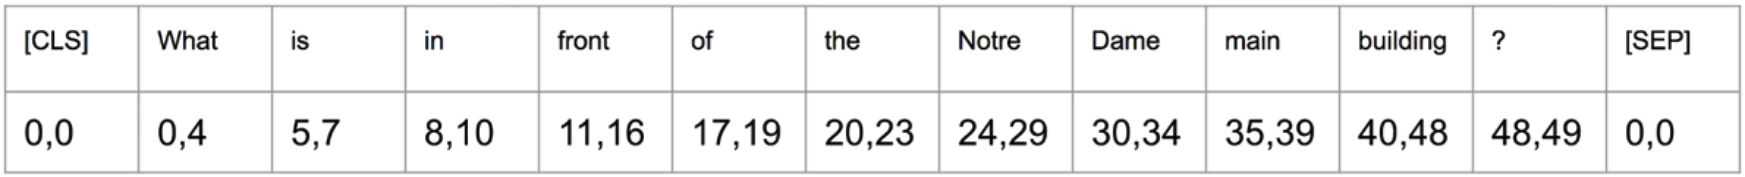

In [128]:
len(inputs['offset_mapping']) # 12 sub-lists

12

In [129]:
len(inputs['offset_mapping'][0]) # the first sub-list consists 100 tuples

100

👆 max_length=100

In [130]:
len(inputs['offset_mapping'][11]) # the last sub-list only consists 85 tuples

85

👆 Some inputs may not be of size 100, as 'return_overflowing_tokens=True' includes additional tokens that couldn't fit within the specified length.

In [131]:
# 2. inspect the value associated with the 'overflow_to_sample_mapping' key:
inputs['overflow_to_sample_mapping']

[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2]

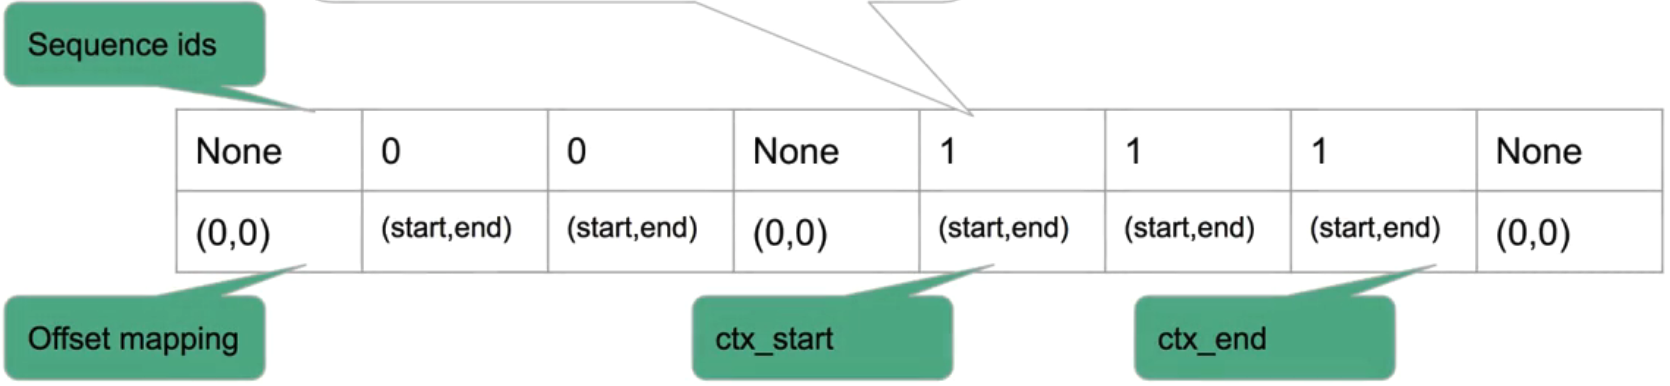

👆 0 corresponds to the tokenized question sequence, and 1 corresponds to the tokenized context sequence.

In [132]:
# recreate inputs for just a single context-question pair:
inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)

inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

In [133]:
len(inputs['offset_mapping'])

4

In [134]:
inputs['offset_mapping']

[[(0, 0),
  (0, 4),
  (5, 7),
  (8, 10),
  (11, 16),
  (17, 19),
  (20, 23),
  (24, 29),
  (30, 34),
  (35, 39),
  (40, 48),
  (48, 49),
  (0, 0),
  (0, 13),
  (13, 15),
  (15, 16),
  (17, 20),
  (21, 27),
  (28, 31),
  (32, 33),
  (34, 42),
  (43, 52),
  (52, 53),
  (54, 56),
  (56, 58),
  (59, 62),
  (63, 67),
  (68, 76),
  (76, 77),
  (77, 78),
  (79, 83),
  (84, 88),
  (89, 91),
  (92, 93),
  (94, 100),
  (101, 107),
  (108, 110),
  (111, 114),
  (115, 121),
  (122, 126),
  (126, 127),
  (128, 139),
  (140, 142),
  (143, 148),
  (149, 151),
  (152, 155),
  (156, 160),
  (161, 169),
  (170, 173),
  (174, 180),
  (181, 183),
  (183, 184),
  (185, 187),
  (188, 189),
  (190, 196),
  (197, 203),
  (204, 206),
  (207, 213),
  (214, 218),
  (219, 223),
  (224, 226),
  (226, 229),
  (229, 232),
  (233, 237),
  (238, 241),
  (242, 248),
  (249, 250),
  (250, 251),
  (251, 254),
  (254, 256),
  (257, 259),
  (260, 262),
  (263, 264),
  (264, 265),
  (265, 268),
  (268, 269),
  (269, 270),
 

In [135]:
len(inputs['offset_mapping'][0])

100

In [136]:
inputs

{'input_ids': [[101, 1327, 1110, 1107, 1524, 1104, 1103, 10360, 8022, 4304, 4334, 136, 102, 22182, 1193, 117, 1103, 1278, 1144, 170, 2336, 1959, 119, 1335, 4184, 1103, 4304, 4334, 112, 188, 2284, 10945, 1110, 170, 5404, 5921, 1104, 1103, 6567, 2090, 119, 13301, 1107, 1524, 1104, 1103, 4304, 4334, 1105, 4749, 1122, 117, 1110, 170, 7335, 5921, 1104, 4028, 1114, 1739, 1146, 14089, 5591, 1114, 1103, 7051, 107, 159, 21462, 1566, 24930, 2508, 152, 1306, 3965, 107, 119, 5893, 1106, 1103, 4304, 4334, 1110, 1103, 19349, 1104, 1103, 11373, 4641, 119, 13301, 1481, 1103, 171, 17506, 9538, 1110, 1103, 144, 102], [101, 1327, 1110, 1107, 1524, 1104, 1103, 10360, 8022, 4304, 4334, 136, 102, 4749, 1122, 117, 1110, 170, 7335, 5921, 1104, 4028, 1114, 1739, 1146, 14089, 5591, 1114, 1103, 7051, 107, 159, 21462, 1566, 24930, 2508, 152, 1306, 3965, 107, 119, 5893, 1106, 1103, 4304, 4334, 1110, 1103, 19349, 1104, 1103, 11373, 4641, 119, 13301, 1481, 1103, 171, 17506, 9538, 1110, 1103, 144, 10595, 2430, 117, 1

In [137]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

In [138]:
print(inputs.sequence_ids)

<bound method BatchEncoding.sequence_ids of {'input_ids': [[101, 1327, 1110, 1107, 1524, 1104, 1103, 10360, 8022, 4304, 4334, 136, 102, 22182, 1193, 117, 1103, 1278, 1144, 170, 2336, 1959, 119, 1335, 4184, 1103, 4304, 4334, 112, 188, 2284, 10945, 1110, 170, 5404, 5921, 1104, 1103, 6567, 2090, 119, 13301, 1107, 1524, 1104, 1103, 4304, 4334, 1105, 4749, 1122, 117, 1110, 170, 7335, 5921, 1104, 4028, 1114, 1739, 1146, 14089, 5591, 1114, 1103, 7051, 107, 159, 21462, 1566, 24930, 2508, 152, 1306, 3965, 107, 119, 5893, 1106, 1103, 4304, 4334, 1110, 1103, 19349, 1104, 1103, 11373, 4641, 119, 13301, 1481, 1103, 171, 17506, 9538, 1110, 1103, 144, 102], [101, 1327, 1110, 1107, 1524, 1104, 1103, 10360, 8022, 4304, 4334, 136, 102, 4749, 1122, 117, 1110, 170, 7335, 5921, 1104, 4028, 1114, 1739, 1146, 14089, 5591, 1114, 1103, 7051, 107, 159, 21462, 1566, 24930, 2508, 152, 1306, 3965, 107, 119, 5893, 1106, 1103, 4304, 4334, 1110, 1103, 19349, 1104, 1103, 11373, 4641, 119, 13301, 1481, 1103, 171, 17506

In [139]:
print(inputs.sequence_ids(0))

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, None]


👆 Sequence IDs indicate to which sequence each input token belongs.

This can be particularly useful in cases where there are multiple sequences in the input, such as in question-answering tasks where you have a question and a context.

0 corresponds to the tokenized question sequence, and 1 corresponds to the tokenized context sequence. Eg:

```
Tokenized Question: [101, 2054, 2003, 102]
Tokenized Context: [1996, 2605, 1997, 102]

{
    "input_ids": [101, 2054, 2003, 102, 1996, 2605, 1997, 102],
    "attention_mask": [1, 1, 1, 1, 1, 1, 1, 1],
    "sequence_ids": [0, 0, 0, 0, 1, 1, 1, 1]
}
```

In [140]:
raw_datasets["train"][1]

{'id': '5733be284776f4190066117f',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'What is in front of the Notre Dame Main Building?',
 'answers': {'text': ['a copper statue of Christ'], 'answer_start': [188]}}

In [141]:
# the position of the answer will change in each window of the context
# the answer is the target for the neural network
# how to recompute the targets for each context window?

answer = raw_datasets["train"][1]["answers"]
answer

{'text': ['a copper statue of Christ'], 'answer_start': [188]}

👆 Problem: this start index (188) is relative to the original full context

# Find the context (the first and last 1):

In [142]:
print(inputs.sequence_ids)

<bound method BatchEncoding.sequence_ids of {'input_ids': [[101, 1327, 1110, 1107, 1524, 1104, 1103, 10360, 8022, 4304, 4334, 136, 102, 22182, 1193, 117, 1103, 1278, 1144, 170, 2336, 1959, 119, 1335, 4184, 1103, 4304, 4334, 112, 188, 2284, 10945, 1110, 170, 5404, 5921, 1104, 1103, 6567, 2090, 119, 13301, 1107, 1524, 1104, 1103, 4304, 4334, 1105, 4749, 1122, 117, 1110, 170, 7335, 5921, 1104, 4028, 1114, 1739, 1146, 14089, 5591, 1114, 1103, 7051, 107, 159, 21462, 1566, 24930, 2508, 152, 1306, 3965, 107, 119, 5893, 1106, 1103, 4304, 4334, 1110, 1103, 19349, 1104, 1103, 11373, 4641, 119, 13301, 1481, 1103, 171, 17506, 9538, 1110, 1103, 144, 102], [101, 1327, 1110, 1107, 1524, 1104, 1103, 10360, 8022, 4304, 4334, 136, 102, 4749, 1122, 117, 1110, 170, 7335, 5921, 1104, 4028, 1114, 1739, 1146, 14089, 5591, 1114, 1103, 7051, 107, 159, 21462, 1566, 24930, 2508, 152, 1306, 3965, 107, 119, 5893, 1106, 1103, 4304, 4334, 1110, 1103, 19349, 1104, 1103, 11373, 4641, 119, 13301, 1481, 1103, 171, 17506

In [143]:
print(inputs.sequence_ids(0))

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, None]


👆 None is a special token.

0 corresponds to the tokenized question sequence,

and 1 corresponds to the tokenized context sequence.

In [144]:
sequence_ids = inputs.sequence_ids(0)

# find the start and end of the context (the first and last '1')
ctx_start = sequence_ids.index(1) # first occurrence
ctx_end = len(sequence_ids) - sequence_ids[::-1].index(1) - 1 # last occurrence

ctx_start, ctx_end

(13, 98)

👆 context starts from idx 13 (counting from the None token) in the sequence IDs

sequence IDs:
[ None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... ]

# Find the answer (within the full context):

In [145]:
# answer = raw_datasets["train"][1]["answers"]
answer

{'text': ['a copper statue of Christ'], 'answer_start': [188]}

In [146]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

In [147]:
# offset mapping associates each token with its start and end character offsets in the original text:
print(inputs['offset_mapping'])

[[(0, 0), (0, 4), (5, 7), (8, 10), (11, 16), (17, 19), (20, 23), (24, 29), (30, 34), (35, 39), (40, 48), (48, 49), (0, 0), (0, 13), (13, 15), (15, 16), (17, 20), (21, 27), (28, 31), (32, 33), (34, 42), (43, 52), (52, 53), (54, 56), (56, 58), (59, 62), (63, 67), (68, 76), (76, 77), (77, 78), (79, 83), (84, 88), (89, 91), (92, 93), (94, 100), (101, 107), (108, 110), (111, 114), (115, 121), (122, 126), (126, 127), (128, 139), (140, 142), (143, 148), (149, 151), (152, 155), (156, 160), (161, 169), (170, 173), (174, 180), (181, 183), (183, 184), (185, 187), (188, 189), (190, 196), (197, 203), (204, 206), (207, 213), (214, 218), (219, 223), (224, 226), (226, 229), (229, 232), (233, 237), (238, 241), (242, 248), (249, 250), (250, 251), (251, 254), (254, 256), (257, 259), (260, 262), (263, 264), (264, 265), (265, 268), (268, 269), (269, 270), (271, 275), (276, 278), (279, 282), (283, 287), (288, 296), (297, 299), (300, 303), (304, 312), (313, 315), (316, 319), (320, 326), (327, 332), (332, 333

In [148]:
# indices marking the beginning and end of the answer within the FULL CONTEXT:
ans_start_char = answer['answer_start'][0] # 188
ans_end_char = ans_start_char + len(answer['text'][0])

# indices marking the beginning and end of the answer within the window:
start_idx = 0
end_idx = 0

offset = inputs['offset_mapping'][0] # offset = [ (0, 0), (0, 4), (5, 7), ... ]
# if the answer is not within the context, target is (start, end) = (0, 0)
if offset[ctx_start][0] > ans_start_char or offset[ctx_end][1] < ans_end_char:
  print("target is (0, 0)")
else: # the answer is within the context
  # find the start and end TOKEN positions (-> human-readable text)
  i = ctx_start
  for start_end_char in offset[ctx_start:]:
    start, end = start_end_char
    if start == ans_start_char:
      start_idx = i
      # don't break yet, still need to find the end_idx as well

    if end == ans_end_char:
      end_idx = i
      break

    i += 1

start_idx, end_idx

(53, 57)

In [149]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

In [150]:
print(inputs['input_ids'])

[[101, 1327, 1110, 1107, 1524, 1104, 1103, 10360, 8022, 4304, 4334, 136, 102, 22182, 1193, 117, 1103, 1278, 1144, 170, 2336, 1959, 119, 1335, 4184, 1103, 4304, 4334, 112, 188, 2284, 10945, 1110, 170, 5404, 5921, 1104, 1103, 6567, 2090, 119, 13301, 1107, 1524, 1104, 1103, 4304, 4334, 1105, 4749, 1122, 117, 1110, 170, 7335, 5921, 1104, 4028, 1114, 1739, 1146, 14089, 5591, 1114, 1103, 7051, 107, 159, 21462, 1566, 24930, 2508, 152, 1306, 3965, 107, 119, 5893, 1106, 1103, 4304, 4334, 1110, 1103, 19349, 1104, 1103, 11373, 4641, 119, 13301, 1481, 1103, 171, 17506, 9538, 1110, 1103, 144, 102], [101, 1327, 1110, 1107, 1524, 1104, 1103, 10360, 8022, 4304, 4334, 136, 102, 4749, 1122, 117, 1110, 170, 7335, 5921, 1104, 4028, 1114, 1739, 1146, 14089, 5591, 1114, 1103, 7051, 107, 159, 21462, 1566, 24930, 2508, 152, 1306, 3965, 107, 119, 5893, 1106, 1103, 4304, 4334, 1110, 1103, 19349, 1104, 1103, 11373, 4641, 119, 13301, 1481, 1103, 171, 17506, 9538, 1110, 1103, 144, 10595, 2430, 117, 170, 14789, 128

# Verify the accuracy of the result:

In [151]:
input_ids = inputs['input_ids'][0]
input_ids[start_idx : end_idx + 1]

[170, 7335, 5921, 1104, 4028]

In [152]:
# use the tokenizer to convert a sequence of token IDs back into human-readable text:
tokenizer.decode(input_ids[start_idx : end_idx + 1])

'a copper statue of Christ'

👆 That is the correct answer.

# Rewrite into a function format:

In [153]:
def find_answer_token_idx(
    ctx_start,
    ctx_end,
    ans_start_char,
    ans_end_char,
    offset):

  start_idx = 0
  end_idx = 0

  if offset[ctx_start][0] > ans_start_char or offset[ctx_end][1] < ans_end_char:
    pass
    # print("target is (0, 0)")
  else:
    # find the start and end TOKEN positions
    # recall: the offset_mapping contains the character positions of each token
    i = ctx_start
    for start_end_char in offset[ctx_start:]:
      start, end = start_end_char
      if start == ans_start_char:
        start_idx = i
        # don't break yet

      if end == ans_end_char:
        end_idx = i
        break

      i += 1
  return start_idx, end_idx

In [154]:
# try it on all context windows
# sometimes, the answer won't appear!

start_idxs = []
end_idxs = []

for i, offset in enumerate(inputs['offset_mapping']):
  # the final window may not be full size - can't assume 100
  sequence_ids = inputs.sequence_ids(i)

  # find start + end of context (first 1 and last 1)
  ctx_start = sequence_ids.index(1)
  ctx_end = len(sequence_ids) - sequence_ids[::-1].index(1) - 1

  start_idx, end_idx = find_answer_token_idx(
    ctx_start,
    ctx_end,
    ans_start_char,
    ans_end_char,
    offset)

  start_idxs.append(start_idx)
  end_idxs.append(end_idx)

start_idxs, end_idxs

([53, 17, 0, 0], [57, 21, 0, 0])

👆 The answer is found between indices 53 and 57 in the first window and between indices 17 and 21 in the second window. It is not present in the remaining windows.

In [155]:
raw_datasets["train"]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 87599
})

# Implement tokenize function (for training data):

In [158]:
# scratch: some questions have leading and/or trailing whitespace
for q in raw_datasets["train"]["question"][:1000]:
  if q.strip() != q: # strip: remove spaces at the beginning and at the end of the string
    print(q)

In what city and state did Beyonce  grow up? 
 The album, Dangerously in Love  achieved what spot on the Billboard Top 100 chart?
Which song did Beyonce sing at the first couple's inaugural ball? 
What event did Beyoncé perform at one month after Obama's inauguration? 
Where was the album released? 
What movie influenced Beyonce towards empowerment themes? 


👆 There are 6 questions with leading and/or trailing whitespaces.

In [159]:
# global variables:
max_length = 384 # Google used 384 for SQuAD
stride = 128

# tokenize the training data (i.e. expand question+context pairs into question+smaller context windows)
def tokenize_fn_train(batch):
  # create a new list where each question from the original batch is stripped of leading and trailing whitespaces
  questions = [q.strip() for q in batch["question"]]

  # tokenize the data (with padding)
  inputs = tokenizer(
    questions,
    batch["context"],
    max_length=max_length,
    truncation="only_second",
    stride=stride,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    padding="max_length",
  )

  offset_mapping = inputs.pop("offset_mapping")
  orig_sample_idxs = inputs.pop("overflow_to_sample_mapping")
  answers = batch['answers']
  start_idxs, end_idxs = [], []

  for i, offset in enumerate(offset_mapping):
    sample_idx = orig_sample_idxs[i]
    answer = answers[sample_idx]

    ans_start_char = answer['answer_start'][0]
    ans_end_char = ans_start_char + len(answer['text'][0])

    sequence_ids = inputs.sequence_ids(i)

    # find start + end of context (first 1 and last 1)
    ctx_start = sequence_ids.index(1)
    ctx_end = len(sequence_ids) - sequence_ids[::-1].index(1) - 1

    start_idx, end_idx = find_answer_token_idx(
      ctx_start,
      ctx_end,
      ans_start_char,
      ans_end_char,
      offset)

    start_idxs.append(start_idx)
    end_idxs.append(end_idx)

  inputs["start_positions"] = start_idxs
  inputs["end_positions"] = end_idxs
  return inputs

# Mapping the tokenize function (for training data):

In [160]:
train_dataset = raw_datasets["train"].map(
  tokenize_fn_train,
  batched=True,
  remove_columns=raw_datasets["train"].column_names,
)

len(raw_datasets["train"]), len(train_dataset)

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

(87599, 88729)

👆 The output dataset is larger than the raw dataset.

# Implement tokenize function (for validation set):

We create two separate functions for training and validation because during evaluation, we will use the string version of answers, which is already included in the devset (no need to build targets).

In [162]:
raw_datasets["validation"]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 10570
})

In [163]:
len(raw_datasets["validation"])

10570

In [166]:
raw_datasets["validation"][0]

{'id': '56be4db0acb8001400a502ec',
 'title': 'Super_Bowl_50',
 'context': 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.',
 'question': 'Which NFL team represented the AFC at Super Bowl 50?',
 'answers': {'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'],


👆 The id is a string.

In [167]:
# tokenize the validation set differently
# we won't need the targets since we will just compare with the original answer
# also: overwrite offset_mapping with Nones in place of question
def tokenize_fn_validation(batch):
  # some questions have leading and/or trailing whitespace
  questions = [q.strip() for q in batch["question"]]

  # tokenize the data (with padding this time)
  # since most contexts are long, we won't bother to pad per-minibatch
  inputs = tokenizer(
    questions,
    batch["context"],
    max_length=max_length,
    truncation="only_second",
    stride=stride,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    padding="max_length",
  )

  # we don't need these later so remove them
  orig_sample_idxs = inputs.pop("overflow_to_sample_mapping")
  sample_ids = []

  # rewrite offset mapping by replacing question tuples with None
  # this will be helpful later on when we compute metrics
  for i in range(len(inputs["input_ids"])):
    sample_idx = orig_sample_idxs[i]
    sample_ids.append(batch['id'][sample_idx])

    sequence_ids = inputs.sequence_ids(i)
    offset = inputs["offset_mapping"][i]
    inputs["offset_mapping"][i] = [
      x if sequence_ids[j] == 1 else None for j, x in enumerate(offset)]

  inputs['sample_id'] = sample_ids
  return inputs

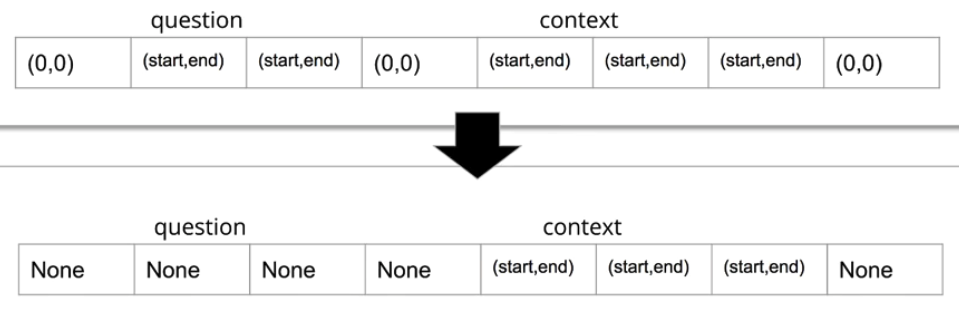

# Mapping the tokenize function (for validation set):

In [168]:
validation_dataset = raw_datasets["validation"].map(
  tokenize_fn_validation,
  batched=True,
  remove_columns=raw_datasets["validation"].column_names,
)

len(raw_datasets["validation"]), len(validation_dataset)

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

(10570, 10822)